# 01 — Data Collection

**Project:** Fentanyl Overdose Death (ODD) Analysis  
**Author:** Mitchell Yorkey 
**Last Updated:** 2026-02-19  

## Purpose
This notebook pulls provisional drug overdose death counts from the CDC's Vital Statistics Rapid Release (VSRR) system. It uses the CDC's Socrata API as the primary source and falls back to a local CSV if the API is unavailable. A timestamped snapshot is saved to `data/raw/` for reproducibility.

## Data Source
- **Dataset:** VSRR Provisional Drug Overdose Death Counts  
- **Publisher:** CDC / National Center for Health Statistics (NCHS)  
- **URL:** https://data.cdc.gov/National-Center-for-Health-Statistics/VSRR-Provisional-Drug-Overdose-Death-Counts/xkb8-kh2a  
- **API Endpoint:** `https://data.cdc.gov/resource/xkb8-kh2a.json`  
- **Update Frequency:** Monthly (provisional, subject to revision)  

---
## 1. Imports and Configuration

In [4]:
import requests
import pandas as pd
import numpy as np
import os
from datetime import datetime
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────────────────
ROOT = Path().resolve().parent  # assumes notebooks/ folder
RAW_DIR = ROOT / "data" / "raw"
PROCESSED_DIR = ROOT / "data" / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ── API Config ─────────────────────────────────────────────────────────────
DATASET_ID = "xkb8-kh2a"
API_BASE = f"https://data.cdc.gov/resource/{DATASET_ID}.json"
PAGE_SIZE = 50000
APP_TOKEN = "gyCKnDytuJigWWnFNtsPElXA5"

# ── Fallback CSV path ──────────────────────────────────────────────────────
FALLBACK_CSV = RAW_DIR / "vsrr_overdose_fallback.csv"

print(f"Root:      {ROOT}")
print(f"Raw dir:   {RAW_DIR}")
print(f"Processed: {PROCESSED_DIR}")
print(f"App token: set ✓")

Root:      C:\Users\Mitch\Documents\fentanyl-odd
Raw dir:   C:\Users\Mitch\Documents\fentanyl-odd\data\raw
Processed: C:\Users\Mitch\Documents\fentanyl-odd\data\processed
App token: set ✓


---
## 2. API Pull Function (with Pagination)

The CDC uses the **Socrata Open Data API (SODA)**. Results are paginated — we request 50,000 rows at a time and loop until the dataset is fully pulled. If the API fails for any reason, we fall back to a local CSV.

In [5]:
def fetch_cdc_vsrr_api(app_token=None, page_size=50000):
    """
    Pull all records from the CDC VSRR dataset via the Socrata API.
    Handles pagination automatically.

    Parameters
    ----------
    app_token : str or None
        Socrata app token for higher rate limits.
    page_size : int
        Number of records per API request.

    Returns
    -------
    pd.DataFrame or None
        Full dataset, or None if the pull failed.
    """
    headers = {"X-App-Token": app_token} if app_token else {}
    all_records = []
    offset = 0

    print("Fetching from CDC Socrata API...")

    while True:
        params = {
            "$limit": page_size,
            "$offset": offset,
            "$order": ":id"
        }

        try:
            response = requests.get(API_BASE, headers=headers, params=params, timeout=30)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"  ✗ API request failed at offset {offset}: {e}")
            return None

        batch = response.json()

        if not batch:
            break

        all_records.extend(batch)
        print(f"  Fetched {len(all_records):,} records so far...")

        if len(batch) < page_size:
            break

        offset += page_size

    if all_records:
        print(f"  ✓ API pull complete. Total records: {len(all_records):,}")
        return pd.DataFrame(all_records)
    else:
        print("  ✗ No records returned from API.")
        return None

---
## 3. Fallback: Load from Local CSV

In [6]:
def load_fallback_csv(path):
    """
    Load the manually downloaded CDC VSRR CSV as a fallback.

    How to get this file manually:
    1. Go to https://data.cdc.gov/National-Center-Health-Statistics/
       VSRR-Provisional-Drug-Overdose-Death-Counts/xkb8-kh2a
    2. Click Export → CSV
    3. Save to data/raw/vsrr_overdose_fallback.csv
    """
    if Path(path).exists():
        print(f"Loading fallback CSV from: {path}")
        df = pd.read_csv(path, dtype=str)
        print(f"  ✓ Loaded {len(df):,} rows from CSV fallback.")
        return df
    else:
        print(f"  ✗ No fallback CSV found at {path}")
        print("    → Download manually from the CDC website and save to data/raw/vsrr_overdose_fallback.csv")
        return None

---
## 4. Main Ingestion Logic — API with CSV Fallback

In [7]:
# ── Try API first ──────────────────────────────────────────────────────────
df_raw = fetch_cdc_vsrr_api(app_token=APP_TOKEN)

# ── Fall back to CSV if API failed ─────────────────────────────────────────
if df_raw is None:
    print("\nFalling back to local CSV...")
    df_raw = load_fallback_csv(FALLBACK_CSV)

if df_raw is None:
    raise RuntimeError(
        "Both API and CSV fallback failed. "
        "Check your internet connection or download the CSV manually."
    )

print(f"\nDataset shape: {df_raw.shape}")
print(f"Columns: {df_raw.columns.tolist()}")

Fetching from CDC Socrata API...
  Fetched 50,000 records so far...
  Fetched 81,270 records so far...
  ✓ API pull complete. Total records: 81,270

Dataset shape: (81270, 12)
Columns: ['state', 'year', 'month', 'period', 'indicator', 'percent_complete', 'percent_pending_investigation', 'state_name', 'footnote', 'footnote_symbol', 'data_value', 'predicted_value']


---
## 5. Save Raw Snapshot with Timestamp

We save an exact snapshot of what we pulled. This is critical for reproducibility — 
CDC provisional data gets revised retroactively, so a dated snapshot lets you 
know exactly what you were working with.

In [8]:
timestamp = datetime.now().strftime("%Y%m%d")
snapshot_path = RAW_DIR / f"vsrr_overdose_raw_{timestamp}.csv"

df_raw.to_csv(snapshot_path, index=False)
print(f"✓ Raw snapshot saved to: {snapshot_path}")
print(f"  Rows: {len(df_raw):,} | Columns: {len(df_raw.columns)}")

✓ Raw snapshot saved to: C:\Users\Mitch\Documents\fentanyl-odd\data\raw\vsrr_overdose_raw_20260219.csv
  Rows: 81,270 | Columns: 12


---
## 6. Initial Inspection

Before cleaning anything, just look at what we have.

In [10]:
df_raw.tail(10)

,state,year,month,period,indicator,percent_complete,percent_pending_investigation,state_name,footnote,footnote_symbol,data_value,predicted_value
81260,YC,2024,December,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.285905578777844,New York City,Underreported due to incomplete data.,*,1619,1679
81261,YC,2025,January,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.33451468248228,New York City,Underreported due to incomplete data.,*,1550,1611
81262,YC,2025,February,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.390920554854981,New York City,Underreported due to incomplete data.,*,1470,1541
81263,YC,2025,March,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.443371061927763,New York City,Underreported due to incomplete data.,*,1411,1494
81264,YC,2025,April,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.489913544668588,New York City,Underreported due to incomplete data.,*,1363,1453
81265,YC,2025,May,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.553382482830723,New York City,Underreported due to incomplete data.,*,1317,1428
81266,YC,2025,June,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.619206192061921,New York City,Underreported due to incomplete data.,*,1268,1389
81267,YC,2025,July,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.698014176722039,New York City,Underreported due to incomplete data.,*,1249,1386
81268,YC,2025,August,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.782475434958983,New York City,Underreported due to incomplete data.,*,1206,1358
81269,YC,2025,September,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",100,0.935406396157249,New York City,Underreported due to incomplete data.,*,1204,1391


In [11]:
df_raw.dtypes

state                            object
year                             object
month                            object
period                           object
indicator                        object
percent_complete                 object
percent_pending_investigation    object
state_name                       object
footnote                         object
footnote_symbol                  object
data_value                       object
predicted_value                  object
dtype: object

In [12]:
# What states/jurisdictions are included?
print("Unique states/jurisdictions:")
state_col_guess = next((c for c in df_raw.columns if 'state' in c.lower()), None)
print(sorted(df_raw[state_col_guess].unique()) if state_col_guess else "Could not detect state column")

Unique states/jurisdictions:
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'YC']


In [13]:
# What indicator types exist?
indicator_col_guess = next((c for c in df_raw.columns if 'indicator' in c.lower()), None)
print("Unique indicators (cause-of-death categories):")
if indicator_col_guess:
    for ind in sorted(df_raw[indicator_col_guess].unique()):
        print(f"  {ind}")

Unique indicators (cause-of-death categories):
  Cocaine (T40.5)
  Heroin (T40.1)
  Methadone (T40.3)
  Natural & semi-synthetic opioids (T40.2)
  Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)
  Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)
  Number of Deaths
  Number of Drug Overdose Deaths
  Opioids (T40.0-T40.4,T40.6)
  Percent with drugs specified
  Psychostimulants with abuse potential (T43.6)
  Synthetic opioids, excl. methadone (T40.4)


In [14]:
# Date range and null check
print("Year range:", df_raw['year'].unique() if 'year' in df_raw.columns else 'see columns above')
print("\nNull counts per column:")
print(df_raw.isnull().sum())

Year range: ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'
 '2025']

Null counts per column:
state                                0
year                                 0
month                                0
period                               0
indicator                            0
percent_complete                     0
percent_pending_investigation        0
state_name                           0
footnote                             0
footnote_symbol                      0
data_value                       14603
predicted_value                  28476
dtype: int64


In [20]:
print(df['state_name'].unique())

['Alaska' 'Alabama' 'Arkansas' 'Arizona' 'California' 'Colorado'
 'Connecticut' 'District of Columbia' 'Delaware' 'Florida' 'Georgia'
 'Hawaii' 'Iowa' 'Idaho' 'Illinois' 'Indiana' 'Kansas' 'Kentucky'
 'Louisiana' 'Massachusetts' 'Maryland' 'Maine' 'Michigan' 'Minnesota'
 'Missouri' 'Mississippi' 'Montana' 'North Carolina' 'North Dakota'
 'Nebraska' 'New Hampshire' 'New Jersey' 'New Mexico' 'Nevada' 'New York'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'United States'
 'Utah' 'Virginia' 'Vermont' 'Washington' 'Wisconsin' 'West Virginia'
 'Wyoming' 'New York City']


In [19]:
print("Null data_value by year:")
print(df.groupby('year')['data_value'].apply(lambda x: x.isnull().sum()))

print("\nNull data_value by state (top 15):")
print(df.groupby('state_name')['data_value'].apply(lambda x: x.isnull().sum()).sort_values(ascending=False).head(15))

Null data_value by year:
year
2015    3054
2016    2536
2017    2376
2018    1946
2019    1277
2020     973
2021     568
2022     407
2023     381
2024     545
2025     540
Name: data_value, dtype: int64

Null data_value by state (top 15):
state_name
North Dakota    1004
Nebraska         963
Puerto Rico      819
Arkansas         795
Alabama          783
Idaho            734
Montana          727
Minnesota        678
Florida          630
Kansas           536
Wyoming          526
Mississippi      503
Michigan         495
California       477
Indiana          450
Name: data_value, dtype: int64


---
## 7. Light Cleaning & Save to Processed

Minimal cleaning here — type casting and column standardization only. 
Deeper analytical filtering happens in `02_eda_national_trend.ipynb`.

In [15]:
df = df_raw.copy()

# ── Standardize column names to snake_case ─────────────────────────────────
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace(r"[^a-z0-9_]", "", regex=True)
)

print("Cleaned column names:")
print(df.columns.tolist())

Cleaned column names:
['state', 'year', 'month', 'period', 'indicator', 'percent_complete', 'percent_pending_investigation', 'state_name', 'footnote', 'footnote_symbol', 'data_value', 'predicted_value']


In [16]:
# ── Cast types ─────────────────────────────────────────────────────────────
# 'data_value' contains suppressed values marked as 'Suppressed' or 'Missing'
# for small counts — coerce these to NaN.

count_col = next((c for c in df.columns if 'data_value' in c or 'death' in c), None)
print(f"Death count column identified as: '{count_col}'")

if count_col:
    df[count_col] = pd.to_numeric(df[count_col], errors='coerce')

if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

if 'month' in df.columns:
    df['month'] = df['month'].astype(str).str.strip()

# Create a proper date column for time series plotting
if 'year' in df.columns and 'month' in df.columns:
    df['date'] = pd.to_datetime(
        df['year'].astype(str) + '-' + df['month'].str[:3],
        format='%Y-%b',
        errors='coerce'
    )
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")

df.dtypes

Death count column identified as: 'data_value'
Date range: 2015-01-01 00:00:00 to 2025-09-01 00:00:00


state                                    object
year                                      Int64
month                                    object
period                                   object
indicator                                object
percent_complete                         object
percent_pending_investigation            object
state_name                               object
footnote                                 object
footnote_symbol                          object
data_value                              float64
predicted_value                          object
date                             datetime64[ns]
dtype: object

In [17]:
# ── Save processed file ────────────────────────────────────────────────────
processed_path = PROCESSED_DIR / f"vsrr_overdose_processed_{timestamp}.csv"
df.to_csv(processed_path, index=False)
print(f"✓ Processed data saved to: {processed_path}")

# Also save a 'latest' version so downstream notebooks don't need a hardcoded date
latest_path = PROCESSED_DIR / "vsrr_overdose_latest.csv"
df.to_csv(latest_path, index=False)
print(f"✓ Also saved as: {latest_path} (overwritten on each pull)")

✓ Processed data saved to: C:\Users\Mitch\Documents\fentanyl-odd\data\processed\vsrr_overdose_processed_20260219.csv
✓ Also saved as: C:\Users\Mitch\Documents\fentanyl-odd\data\processed\vsrr_overdose_latest.csv (overwritten on each pull)


---
## 8. Quick Sanity Check — National Synthetic Opioid Deaths

Filter to synthetic opioid deaths at the national level and confirm 
we can see the rise-and-fall shape described in Vangelov et al. (2026).

> The article reports fentanyl ODDs peaking at **76,000 in 2023** and 
> dropping by over a third by end of 2024. We should see that shape here.

In [21]:
import matplotlib.pyplot as plt

mask = (
    (df['state_name'] == 'United States') &
    (df['indicator'] == 'Synthetic opioids, excl. methadone (T40.4)')
)

df_national_synth = df[mask].copy()
df_national_synth = df_national_synth.sort_values('date').dropna(subset=['date', 'data_value'])

print(f"Rows matching filter: {len(df_national_synth)}")
df_national_synth[['date', 'data_value']].tail(12)

Rows matching filter: 129


,date,data_value
68874,2024-10-01,52875.0
68875,2024-11-01,50724.0
68876,2024-12-01,48661.0
68877,2025-01-01,46975.0
68878,2025-02-01,45430.0
68879,2025-03-01,44336.0
68880,2025-04-01,43126.0
68881,2025-05-01,41976.0
68882,2025-06-01,40859.0
68883,2025-07-01,40004.0


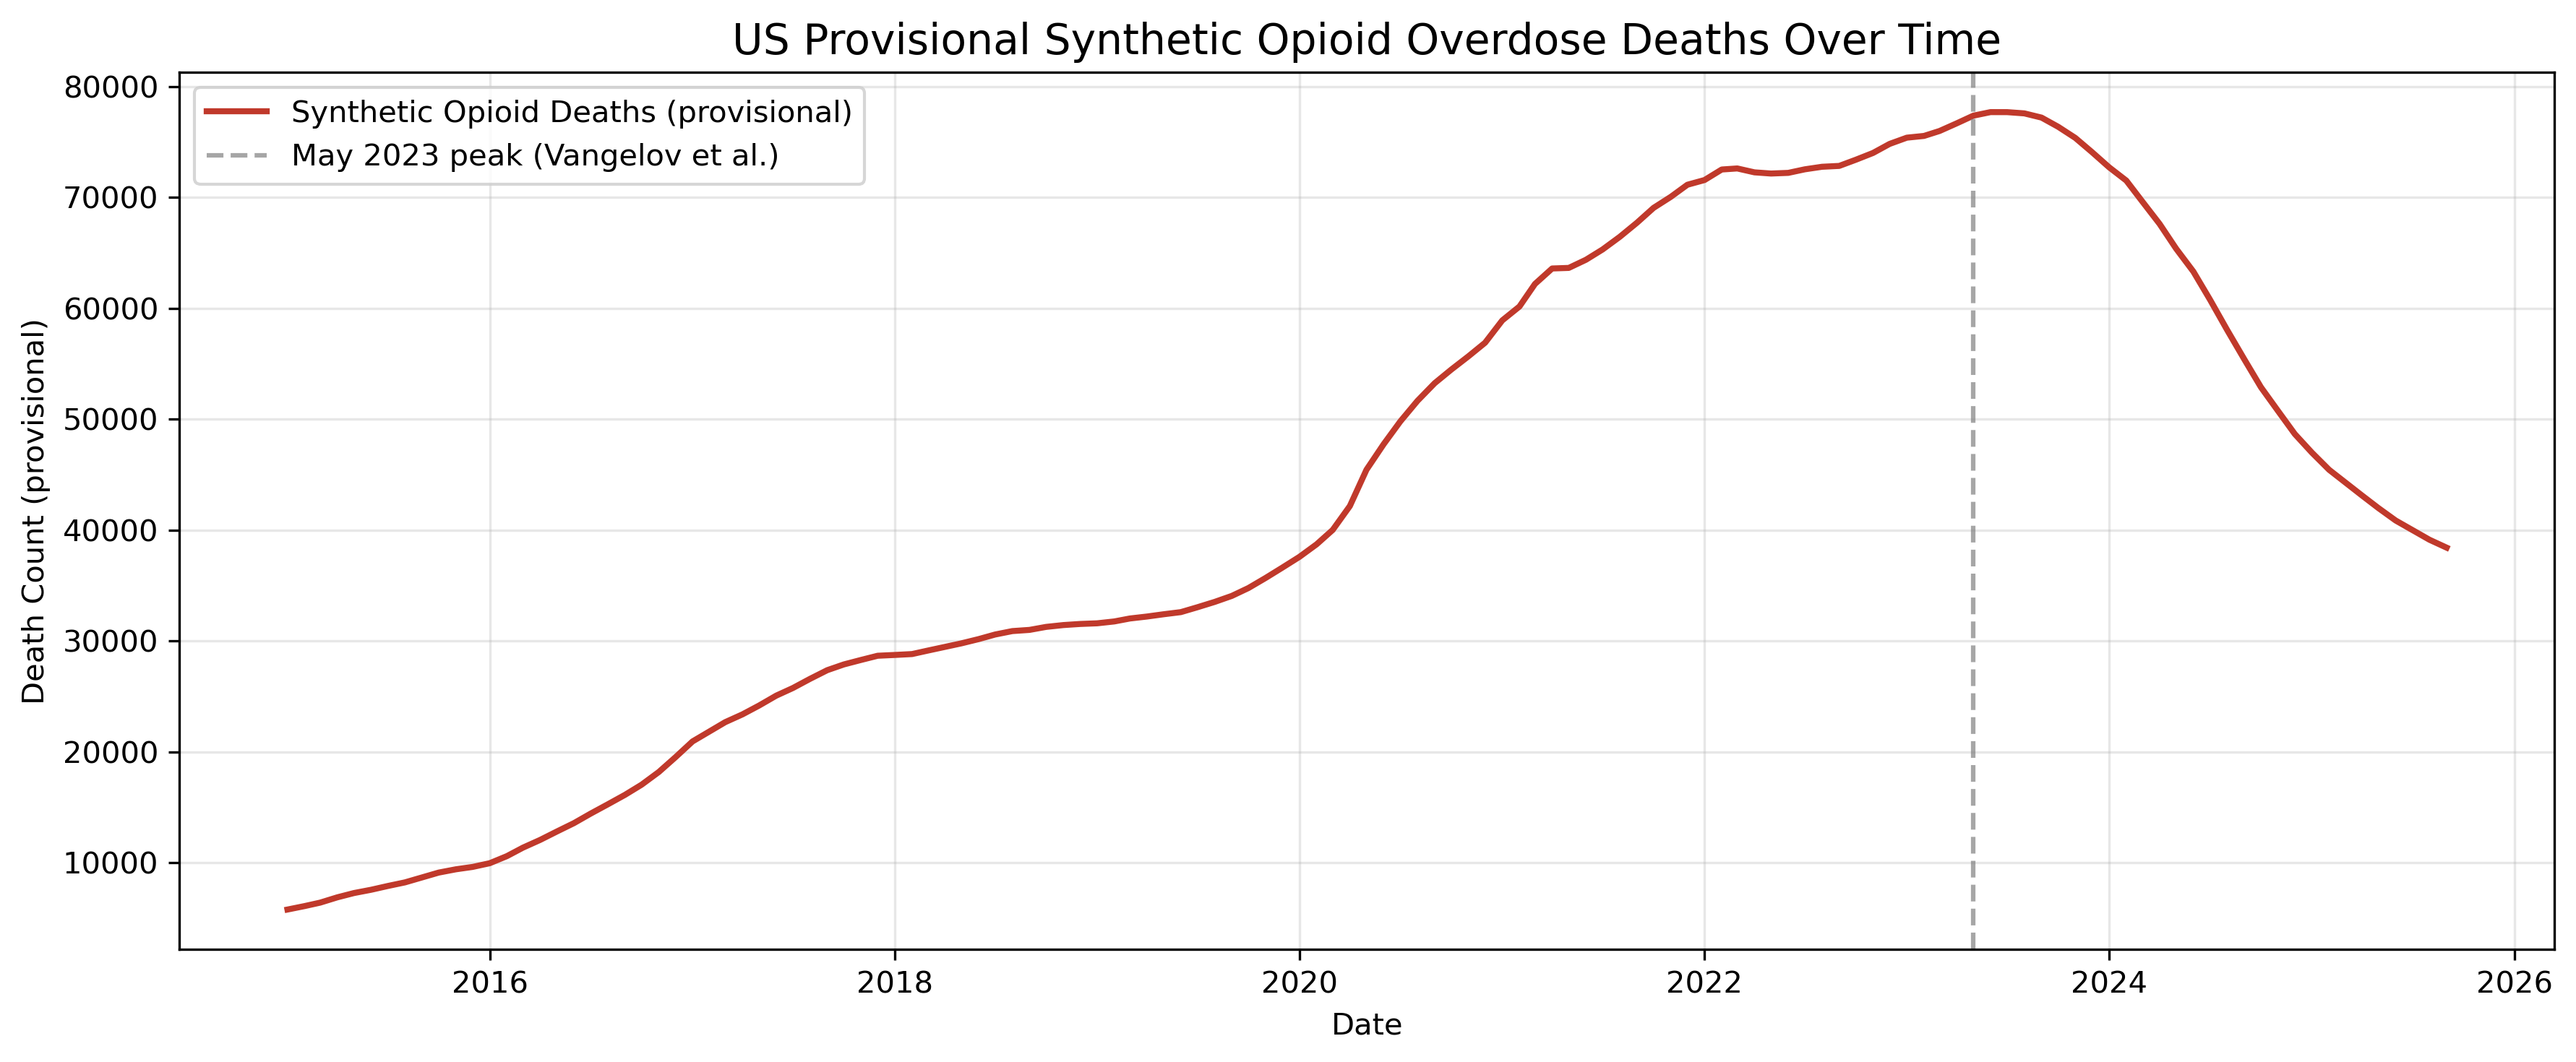

In [23]:
fig, ax = plt.subplots(figsize=(12, 5),dpi=300)

ax.plot(
    df_national_synth['date'],
    df_national_synth['data_value'],
    color='#c0392b',
    linewidth=2,
    label='Synthetic Opioid Deaths (provisional)'
)

ax.axvline(
    pd.Timestamp('2023-05-01'),
    color='gray', linestyle='--', alpha=0.7,
    label='May 2023 peak (Vangelov et al.)'
)

ax.set_title('US Provisional Synthetic Opioid Overdose Deaths Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Death Count (provisional)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9. Session Summary

In [24]:
print("=" * 55)
print("DATA COLLECTION SUMMARY")
print("=" * 55)
print(f"Run date:          {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Source:            CDC VSRR API (xkb8-kh2a)")
print(f"Total rows pulled: {len(df):,}")
print(f"Date range:        {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Raw snapshot:      {snapshot_path.name}")
print(f"Processed file:    {processed_path.name}")
print("")
print("Next step → 02_eda_national_trend.ipynb")
print("=" * 55)

DATA COLLECTION SUMMARY
Run date:          2026-02-19 00:51
Source:            CDC VSRR API (xkb8-kh2a)
Total rows pulled: 81,270
Date range:        2015-01-01 to 2025-09-01
Raw snapshot:      vsrr_overdose_raw_20260219.csv
Processed file:    vsrr_overdose_processed_20260219.csv

Next step → 02_eda_national_trend.ipynb
